In [316]:
import SimpleITK as sitk

import itk
import guiPoint

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy import linalg

from ipywidgets import interact, fixed
from __future__ import print_function

import sys
from myshow import myshow, myshow3d

import numpy as np
from scipy import linalg
from importlib import reload

from ipywidgets import interact, fixed

In [317]:
threeD_image = sitk.ReadImage("5342_3D_8_51519.mha")
T1_image = sitk.ReadImage("5342_T1_9_68083.mha")
T2_image = sitk.ReadImage("5342_T2_5_16889.mha")
Flair_image = sitk.ReadImage("5342_Flair_4_19844.mha")
print(threeD_image.GetPixelIDTypeAsString() )
print(T1_image.GetPixelIDTypeAsString() )
print(T2_image.GetPixelIDTypeAsString() )
print(Flair_image.GetPixelIDTypeAsString() )
print(threeD_image.GetSize())
print(T1_image.GetSize())
print(T2_image.GetSize())
print(Flair_image.GetSize())

16-bit signed integer
16-bit signed integer
16-bit signed integer
16-bit signed integer
(512, 512, 60)
(256, 256, 20)
(256, 256, 20)
(256, 256, 20)


## Seed definition

In [318]:
seed_3D = [(319,315,23)]
#seeds = [(325, 314, 29), (345, 275, 22), (305, 350, 22)]
seed_T1 = [(171, 152, 8)]
seed_T2 = [(175, 152, 9)]
seed_Flair =[(154, 170, 9)]

## Visualization

In [319]:
%matplotlib inline
myshow(T1_image)
myshow(T2_image)
myshow(Flair_image)
myshow3d(threeD_image)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## Registration

In [320]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

In [321]:
fixed_image =  T1_image
moving_image = threeD_image

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

A Jupyter Widget

In [322]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

In [323]:
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_resampled.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_resampled)));

A Jupyter Widget

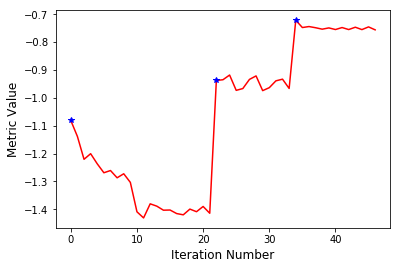

In [324]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform_3D = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [325]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.7446631426991697
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 13.


In [326]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform_3D, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

In [327]:
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_resampled.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_resampled)));

A Jupyter Widget

In [328]:
threeD_image_r = moving_resampled 

In [329]:
fixed_image =  T1_image
moving_image = T2_image

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

A Jupyter Widget

In [330]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

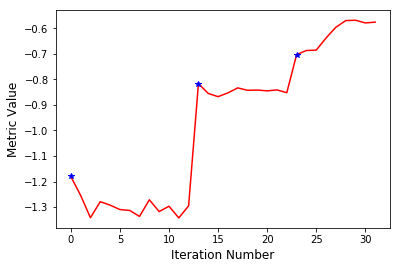

In [331]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))
final_inverse_transform = final_transform.GetInverse()

In [332]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

In [333]:
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_resampled.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_resampled)));

A Jupyter Widget

In [334]:
T2_image = moving_resampled

In [335]:
fixed_image =  T1_image
moving_image = Flair_image

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

A Jupyter Widget

In [336]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

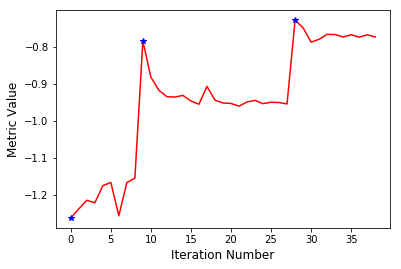

In [337]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [338]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

In [339]:
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_resampled.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_resampled)));

A Jupyter Widget

In [340]:
Flair_image = moving_resampled

## Get Anatomical Structure

In [341]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(1400)
binaryFilter.SetUpperThreshold(1700)
T2_image_water_segment = binaryFilter.Execute(T2_image)
myshow(T2_image_water_segment)

A Jupyter Widget

In [342]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
T2_image_water_segment = closingFilter.Execute(T2_image_water_segment)
myshow(T2_image_water_segment)

A Jupyter Widget

In [343]:
dilateFilter= sitk.BinaryDilateImageFilter()
T2_image_water_segment1 = dilateFilter.Execute(T2_image_water_segment)
myshow(T2_image_water_segment1)

A Jupyter Widget

In [344]:
openingFilter = sitk.BinaryMorphologicalOpeningImageFilter()
openingFilter.SetKernelRadius(2)
T2_image_water_segment = openingFilter.Execute(T2_image_water_segment)
myshow(T2_image_water_segment)

A Jupyter Widget

In [345]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(-100)
binaryFilter.SetUpperThreshold(50)
threeD_image_water_segment = binaryFilter.Execute(threeD_image_r)
myshow(threeD_image_water_segment)

A Jupyter Widget

In [346]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
threeD_image_water_segment = closingFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_segment)

A Jupyter Widget

In [347]:
openingFilter = sitk.BinaryMorphologicalOpeningImageFilter()
threeD_image_water_segment1 = openingFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_segment1)

A Jupyter Widget

In [348]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(1200)
binaryFilter.SetUpperThreshold(1700)
Flair_image_skull_segment = binaryFilter.Execute(Flair_image)
myshow(Flair_image_skull_segment)

A Jupyter Widget

In [349]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
Flair_image_skull_segment = closingFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_segment)

A Jupyter Widget

In [350]:
dilateFilter= sitk.BinaryDilateImageFilter()
Flair_image_skull_segment = dilateFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_segment)

A Jupyter Widget

In [351]:
openingFilter = sitk.BinaryMorphologicalOpeningImageFilter()
openingFilter.SetKernelRadius(2)
Flair_image_skull_segment = openingFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_segment)

A Jupyter Widget

## Remove Anatomical structures

In [352]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(0)
binaryFilter.SetUpperThreshold(0)
T2_image_water_mask = binaryFilter.Execute(T2_image_water_segment)
myshow(T2_image_water_mask )
threeD_image_water_mask = binaryFilter.Execute(threeD_image_water_segment)
myshow(T2_image_water_mask )
Flair_image_skull_mask = binaryFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_mask )


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [353]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(0)
binaryFilter.SetUpperThreshold(0)
threeD_image_water_mask = binaryFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_mask )

A Jupyter Widget

In [354]:
maskFilter = sitk.MaskImageFilter()

T1_image = maskFilter.Execute(T1_image,threeD_image_water_mask)
T2_image = maskFilter.Execute(T2_image,threeD_image_water_mask)
Flair_image = maskFilter.Execute(Flair_image,threeD_image_water_mask)

T1_image = maskFilter.Execute(T1_image,Flair_image_skull_mask)
T2_image = maskFilter.Execute(T2_image,Flair_image_skull_mask)
Flair_image = maskFilter.Execute(Flair_image,Flair_image_skull_mask)
myshow(T1_image)
myshow(T2_image)
myshow(Flair_image)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## Segmentation 3D

In [355]:
%matplotlib inline
blurFilter = sitk.CurvatureFlowImageFilter()
blurFilter.SetNumberOfIterations( 3 )
blurFilter.SetTimeStep( 0.15 )
image = blurFilter.Execute(threeD_image)
myshow(image)

A Jupyter Widget

In [356]:
%matplotlib inline
ThresholdFilter = sitk.ConnectedThresholdImageFilter()
ThresholdFilter.SetSeedList( [(319,315,23)])
ThresholdFilter.SetLower(20)
ThresholdFilter.SetUpper(70)
image1 = ThresholdFilter.Execute(image)
#myshow(sitk.LabelOverlay(threeD_image, seg), "Connected Threshold")
myshow(image1)

A Jupyter Widget

In [357]:
#%matplotlib inline
#Threshold2Filter = sitk.ConfidenceConnectedImageFilter()
#Threshold2Filter.SetInitialNeighborhoodRadius(5)
#Threshold2Filter.SetMultiplier(2)
#Threshold2Filter.SetNumberOfIterations(15)
#Threshold2Filter.SetSeedList([(319,315,23)])
#image2 = Threshold2Filter.Execute(image)
#myshow(image2)

In [358]:
%matplotlib inline
gradientFilter = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
#sigma = sys.argv[3]
#sigma = sigma[1:len(sigma)-1]
gradientFilter.SetSigma(0.7)
image2 = gradientFilter.Execute(image)
myshow(image2)

A Jupyter Widget

In [359]:
sigmoidFilter = sitk.SigmoidImageFilter()
sigmoidFilter.SetAlpha(-7.0)
sigmoidFilter.SetBeta(12.0)
image3 = sigmoidFilter.Execute(image2)
myshow(image3)

A Jupyter Widget

In [360]:
fastFilter = sitk.FastMarchingImageFilter()
fastFilter.SetTrialPoints([(319,315,23)])
#fastFilter.SetTrialPoints([(325, 314, 29), (345, 275, 22), (305, 350, 22)])
fastFilter.SetStoppingValue(0.06)
image4 = fastFilter.Execute(image3)
myshow(image4)

A Jupyter Widget

In [361]:
fastFilter = sitk.FastMarchingImageFilter()
#fastFilter.SetTrialPoints([(319,315,23)])
fastFilter.SetTrialPoints([(325, 314, 29), (345, 275, 22), (305, 350, 22)])
fastFilter.SetStoppingValue(0.06)
image4 = fastFilter.Execute(image3)
myshow(image4)

#sitk.Show(image4)
binaryFilter4 = sitk.BinaryThresholdImageFilter()
binaryFilter4.SetLowerThreshold(0)
binaryFilter4.SetUpperThreshold(1)
image4_segment = binaryFilter4.Execute(image4)
myshow(image4_segment)



A Jupyter Widget

A Jupyter Widget

In [362]:
#binaryFilter = sitk.BinaryThresholdImageFilter()
#binaryFilter.SetLowerThreshold(0)
#binaryFilter.SetUpperThreshold(100)
#image4 = binaryFilter.Execute(image4)
#myshow(image4 )

In [363]:
castFilter = sitk.CastImageFilter()
castFilter.SetOutputPixelType(sitk.sitkFloat64 )
image3 = castFilter.Execute(image3)
image4 = castFilter.Execute(image4)

In [364]:
shapefilter= sitk.ShapeDetectionLevelSetImageFilter()
#shapefilter= sitk.GeodesicActiveContourLevelSetImageFilter()
#shape_image = shapefilter.New()
#shapefilter.SetInput(image4)
#shapefilter.SetFeatureImage(image3)
#image5 = shape_image.GetOutput()
#print(image4.GetPixelID())
#print(image3.GetPixelID())
#print(image4.GetSize())
#print(image3.GetSize())
shapefilter.SetPropagationScaling( 10 )
shapefilter.SetCurvatureScaling( 0.5 )
#shapefilter.SetAdvectionScaling( 1.0 )
shapefilter.SetMaximumRMSError( 0.01 )
shapefilter.SetNumberOfIterations( 10 )

image5 = shapefilter.Execute(image4*100.0,image3)

myshow(image5)

#sitk.Show(image5)
writer = sitk.ImageFileWriter()
writer.SetFileName("shapefilter_3D_in.nii")
writer.Execute(image4*-100.0)
writer.SetFileName("shapefilter_3D.nii")
writer.Execute(image5)

binaryFilter5 = sitk.BinaryThresholdImageFilter()
binaryFilter5.SetLowerThreshold(-10000)
binaryFilter5.SetUpperThreshold(0)
image5_segment = binaryFilter5.Execute(image5)
myshow(image5_segment)



A Jupyter Widget

A Jupyter Widget

In [365]:
shapefilter= sitk.ShapeDetectionLevelSetImageFilter()
#shape_image = shapefilter.New()
#shapefilter.SetInput(image4)
#shapefilter.SetFeatureImage(image3)
#image5 = shape_image.GetOutput()
#print(image4.GetPixelID())
#print(image3.GetPixelID())
#print(image4.GetSize())
#print(image3.GetSize())
shapefilter.SetPropagationScaling( 1 )
shapefilter.SetCurvatureScaling( 1 )
shapefilter.SetMaximumRMSError( 0.02 )
shapefilter.SetNumberOfIterations( 800 )

image5 = shapefilter.Execute(image4,image3)

myshow(image5)

A Jupyter Widget

In [366]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(-1000)
binaryFilter.SetUpperThreshold(10)
threeD_segment = binaryFilter.Execute(image5)
myshow(threeD_segment)

A Jupyter Widget

In [367]:
rescaleFilter = sitk.RescaleIntensityImageFilter()
image4 = rescaleFilter.Execute(image4)


In [368]:

# Write out the result
#
writer = sitk.ImageFileWriter()
writer.SetFileName("fastmarchingfilter_3D.nii")
writer.Execute(image4)

## Segmentation T1

In [369]:
castFilter = sitk.CastImageFilter()
castFilter.SetOutputPixelType(sitk.sitkFloat64 )
T1_image = castFilter.Execute(T1_image)
myshow(T1_image)

A Jupyter Widget

In [370]:
blurFilter = sitk.CurvatureFlowImageFilter()
blurFilter.SetNumberOfIterations( 3 )
blurFilter.SetTimeStep( 0.15 )
T1_image = blurFilter.Execute(T1_image)
myshow(T1_image) 

A Jupyter Widget

In [371]:
adaptiveFilter = sitk.AdaptiveHistogramEqualizationImageFilter()
adaptiveFilter.SetAlpha(0.5)
adaptiveFilter.SetBeta(1)
T1_image1 = adaptiveFilter.Execute(T1_image)
myshow(T1_image1)

A Jupyter Widget

In [372]:
gradientFilter = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
#sigma = sys.argv[3]
#sigma = sigma[1:len(sigma)-1]
gradientFilter.SetSigma(0.8)
T1_image2 = gradientFilter.Execute(T1_image1)
myshow(T1_image2)

A Jupyter Widget

In [373]:
sigmoidFilter = sitk.SigmoidImageFilter()
sigmoidFilter.SetAlpha(-70.0)
sigmoidFilter.SetBeta(60.0)
T1_image3= sigmoidFilter.Execute(T1_image2)
myshow(T1_image3)

A Jupyter Widget

In [374]:
fastFilter = sitk.FastMarchingImageFilter()
#fastFilter.SetTrialPoints(seed_T1)
fastFilter.SetTrialPoints([(171, 153, 8), (187, 130, 7)])
fastFilter.SetStoppingValue(0.15)
T1_image4 = fastFilter.Execute(T1_image3)
myshow(T1_image4)

A Jupyter Widget

In [375]:
cannyFilter = sitk.CannyEdgeDetectionImageFilter()
cannyFilter.SetLowerThreshold(100)
cannyFilter.SetUpperThreshold(500)
cannyFilter.SetVariance([5,5,5])
cannyFilter.SetMaximumError(0.1)
T1_image2 = cannyFilter.Execute(T1_image)
myshow(T1_image2)

A Jupyter Widget

In [376]:
writer = sitk.ImageFileWriter()
writer.SetFileName("cannyfilter_T1_in.nii")
writer.Execute(T1_image)


In [377]:
%matplotlib inline
blurFilter = sitk.CurvatureFlowImageFilter()
blurFilter.SetNumberOfIterations( 3 )
blurFilter.SetTimeStep( 0.15 )
T1_image1 = blurFilter.Execute(T1_image)
myshow(T1_image1)

A Jupyter Widget

In [378]:
ThresholdFilter = sitk.ConnectedThresholdImageFilter()
ThresholdFilter.SetSeedList(seed_T1)
ThresholdFilter.SetLower(600)
ThresholdFilter.SetUpper(1000)
T1_image2 = ThresholdFilter.Execute(T1_image1)
#myshow(sitk.LabelOverlay(threeD_image, seg), "Connected Threshold")
myshow(T1_image2)

A Jupyter Widget

## Segmentation T2

In [379]:
myshow(T2_image)

A Jupyter Widget

In [380]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(1500)
binaryFilter.SetUpperThreshold(1700)
T2_image_water_segment = binaryFilter.Execute(T2_image)
myshow(T2_image_water_segment)

A Jupyter Widget

In [381]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
T2_image_water_segment = closingFilter.Execute(T2_image_water_segment)
myshow(T2_image_water_segment)

A Jupyter Widget

In [382]:
%matplotlib inline
Threshold2Filter = sitk.ConfidenceConnectedImageFilter()
Threshold2Filter.SetInitialNeighborhoodRadius(20)
Threshold2Filter.SetMultiplier(1.1)
Threshold2Filter.SetNumberOfIterations(50)
Threshold2Filter.SetSeedList([(166,176,9)])
T2_image2= Threshold2Filter.Execute(T2_image)
myshow(T2_image2)


A Jupyter Widget

In [383]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(0)
binaryFilter.SetUpperThreshold(0)
T2_image3 = binaryFilter.Execute(T2_image2)
myshow(T2_image3 )

A Jupyter Widget

In [384]:
morphFilter = sitk.BinaryMorphologicalOpeningImageFilter()
morphFilter.SetKernelRadius(1)
T2_image4 = morphFilter.Execute(T2_image3)
myshow(T2_image4)

A Jupyter Widget

In [385]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
closingFilter.SetKernelRadius(8)
T2_image5 = closingFilter.Execute(T2_image4)
myshow(T2_image5)

A Jupyter Widget

In [386]:
ThresholdFilter = sitk.ConnectedThresholdImageFilter()
ThresholdFilter.SetSeedList([(165,135,9)])
ThresholdFilter.SetLower(1)
ThresholdFilter.SetUpper(1)
T2_image6 = ThresholdFilter.Execute(T2_image5)
#myshow(sitk.LabelOverlay(threeD_image, seg), "Connected Threshold")
myshow(T2_image6)
myshow(T2_image)

A Jupyter Widget

A Jupyter Widget

In [387]:
seg = sitk.Image(T2_image.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(T2_image)
seg[(175, 152, 9)] = 1
seg = sitk.BinaryDilate(seg, 3)

In [388]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

In [389]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(700)
lsFilter.SetUpperThreshold(1500)
lsFilter.SetNumberOfIterations(1000)
lsFilter.SetCurvatureScaling(.2)
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
T2_image_ls = lsFilter.Execute(init_ls, sitk.Cast(T2_image, sitk.sitkFloat32))
myshow(T2_image_ls)

A Jupyter Widget

In [390]:
writer = sitk.ImageFileWriter()
writer.SetFileName("T2_segment.mha")
writer.Execute(T2_image3)

## Obtain Masks

In [391]:
maskFilter = sitk.MaskImageFilter()
threeD_tumor = maskFilter.Execute(threeD_image,threeD_segment)
myshow(threeD_tumor)

A Jupyter Widget

## Feature Analysis 

In [392]:
binaryFilter = sitk.BinaryImageToLabelMapFilter()
threeD_segment_label = binaryFilter.Execute(threeD_segment)

In [393]:
shapeFilter= sitk.LabelShapeStatisticsImageFilter()
test = shapeFilter.Execute(threeD_segment)
print(shapeFilter.GetNumberOfLabels())
print(shapeFilter.GetPerimeter(1))

1
314740.2746256166


In [394]:
shapeFilter= sitk.LabelShapeStatisticsImageFilter()
test = shapeFilter.Execute(image2)
print(shapeFilter.GetPerimeter(image2,'int64_t'))

RuntimeError: Exception thrown in SimpleITK LabelShapeStatisticsImageFilter_Execute: /Users/blowekamp/miniconda2/conda-bld/simpleitk_1502125589355/work/Code/Common/include/sitkMemberFunctionFactory.hxx:196:
sitk::ERROR: Pixel type: 32-bit float is not supported in 3D byN3itk6simple31LabelShapeStatisticsImageFilterE

In [ ]:
shapeFilter= sitk.LabelShapeStatisticsImageFilter()
test = shapeFilter.Execute(threeD_segment_label)